#Маленькие выборки из скошенных распределений

Скошенное распределение — это асимметричное распределение, у которого один из хвостов более тяжёлый.

Пример — логнормальное распределение:


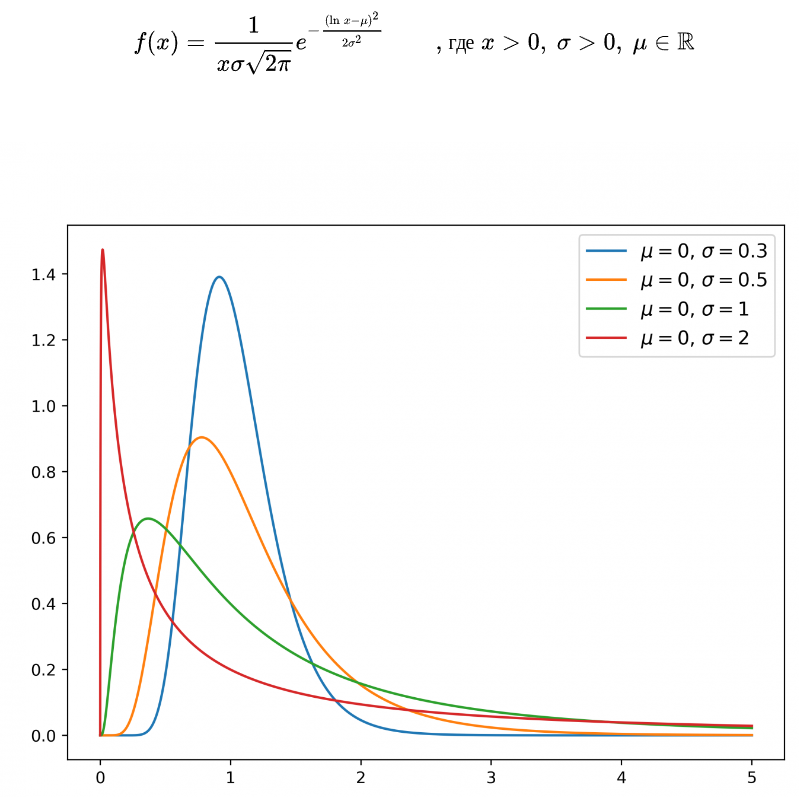


Считаем выборку маленькой, если распределение её среднего имеет скошенное распределение.

Оценки функций плотностей распределений среднего для разных размеров выборок:

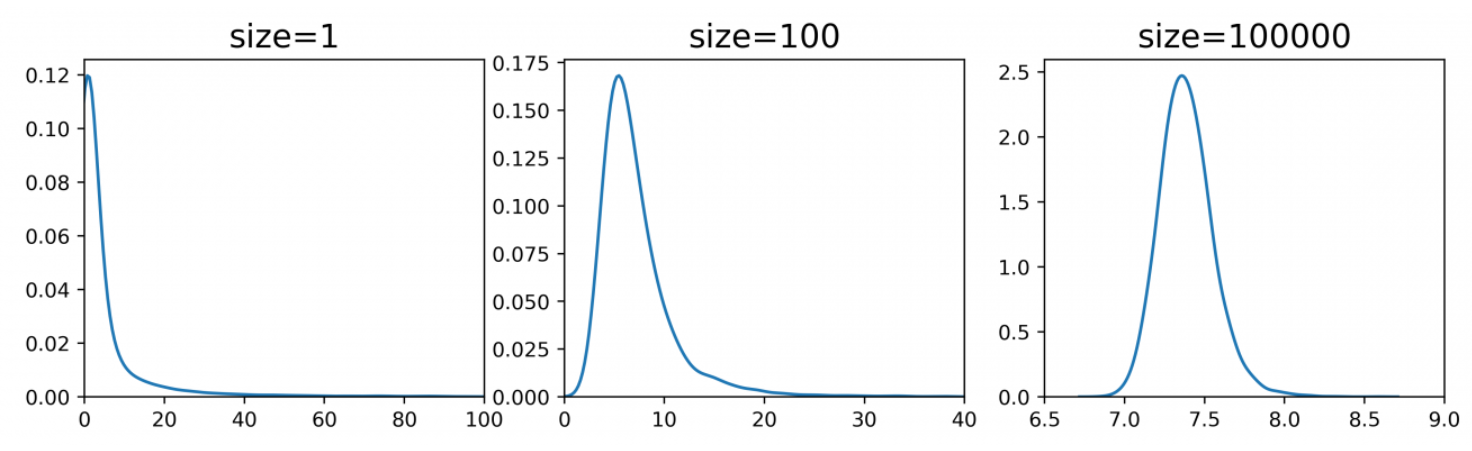

Покажем, что классические критерии, которые используются для проверки гипотезы о равенстве средних, работают некорректно на таких данных.

Пример на синтетических А/А тестах с помощью теста Стьюдента:

100%|██████████| 10000/10000 [00:28<00:00, 353.08it/s]


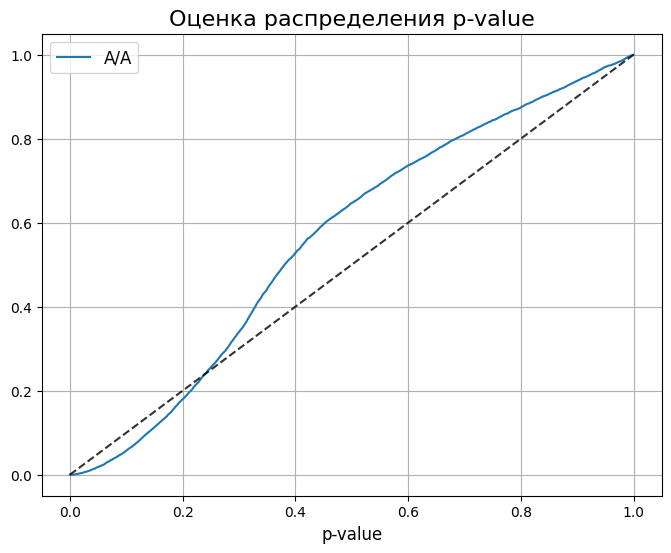

In [2]:
from collections import defaultdict
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcParams["figure.figsize"] = [8, 6]


def plot_pvalue_distribution(dict_pvalues):
    """Графики распределения p-value."""
    X = np.linspace(0, 1, 1000)
    for key, pvalues in dict_pvalues.items():
        Y = [np.mean(pvalues < x) for x in X]
        plt.plot(X, Y, label=key)
    plt.plot([0, 1], [0, 1], "--k", alpha=0.8)
    plt.title("Оценка распределения p-value", size=16)
    plt.xlabel("p-value", size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()


# генерируем выборки размера 10 из логнормального распределения,
# чтобы проверить гипотезу о равенстве средних

sample_size = 10
sigma = 2
dict_pvalues = defaultdict(list)
for _ in tqdm(range(10_000)):
    a, b = np.random.lognormal(sigma=sigma, size=(2, sample_size))
    _, pvalue = stats.ttest_ind(a, b)
    dict_pvalues["A/A"].append(pvalue)
plot_pvalue_distribution(dict_pvalues)


100%|██████████| 10000/10000 [02:55<00:00, 56.97it/s]


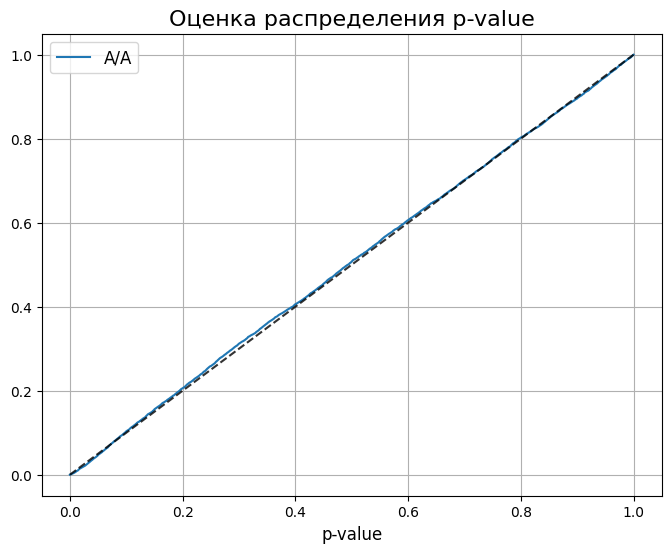

In [3]:
# генерируем выборки размера 100_000 из логнормального распределения,
# чтобы проверить гипотезу о равенстве средних

sample_size = 100_000
sigma = 2
dict_pvalues = defaultdict(list)
for _ in tqdm(range(10_000)):
    a, b = np.random.lognormal(sigma=sigma, size=(2, sample_size))
    _, pvalue = stats.ttest_ind(a, b)
    dict_pvalues["A/A"].append(pvalue)
plot_pvalue_distribution(dict_pvalues)


Можно попробовать заменить критерий Стьюдента на критерий Манна-Уитни - распределение p-value на синтетических А/А тестах станет равномерным:

100%|██████████| 10000/10000 [00:09<00:00, 1066.58it/s]


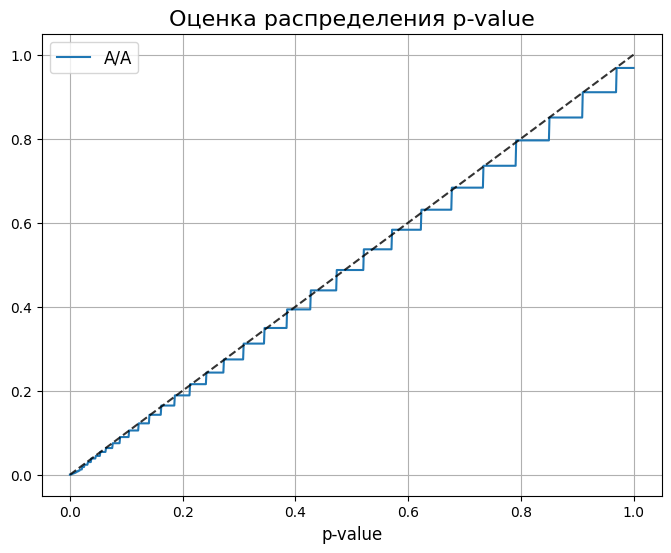

In [8]:
sample_size = 10
sigma = 2
dict_pvalues = defaultdict(list)
for _ in tqdm(range(10_000)):
    a, b = np.random.lognormal(sigma=sigma, size=(2, sample_size))
    # _, pvalue = stats.ttest_ind(a, b)
    pvalue = stats.mannwhitneyu(a, b).pvalue
    dict_pvalues["A/A"].append(pvalue)
plot_pvalue_distribution(dict_pvalues)

Однако, критерий Манна-Уитни в общем случае не проверяет гипотезу о равенстве средних.

In [4]:
# для двух выборок с одинаковым средним критерий Манна-Уитни может отклонять нулевую гипотезу

a = np.hstack([np.linspace(0, 1, 30), np.linspace(8, 9, 10)])
b = np.linspace(2, 3, 40)
pvalue = stats.mannwhitneyu(a, b).pvalue
print(f'разница средних = {a.mean() - b.mean()}')
print(f'pvalue = {pvalue:0.5f}')

разница средних = 0.0
pvalue = 0.00012


In [15]:
# увеличение размера выборок не решает проблему

a = np.hstack([np.linspace(0, 1, 3000), np.linspace(8, 9, 1000)])
b = np.linspace(2, 3, 4000)
pvalue = stats.mannwhitneyu(a, b).pvalue
print(f'разница средних = {a.mean() - b.mean()}')
print(f'pvalue = {pvalue:0.5f}')

разница средних = 0.0
pvalue = 0.00000


Бутстреп для маленьких выборок из скошенных распределений тоже работает некорректно - он строит оценку на основе данных эксперимента, которых не хватает для достаточно точного описания распределения статистики, имеющей особенности.

Строим свой статистический критерий.

Как строят статистические критерии? Обычно, для проверки нулевой гипотезы $H_0$ против альтернативной гипотезы $H_1$ выбирается некоторая статистика $T=T(X^n)$, обладающая двумя свойствами:

Если $H_0$ верна, то статистика $T$ имеет некоторое непрерывное распределение $G$, в пределе не зависящее от $$;

Если $H_0$ неверна, то $|T (X^n)| \overset{P}{\to} \infty$ при $n \to \infty$.

Зная распределение статистики при верности нулевой гипотезы $G$, можно определить область $W$, в которую статистика $T$ попадает с вероятность $1-\alpha$. Конкретные границы области $W$ выбирают так, чтобы мощность критерия была максимальной. Если значение статистики попадает в область $W$, то нулевая гипотеза не отклоняется, иначе значение статистики попадает в критическую область, и нулевая гипотеза отклоняется.

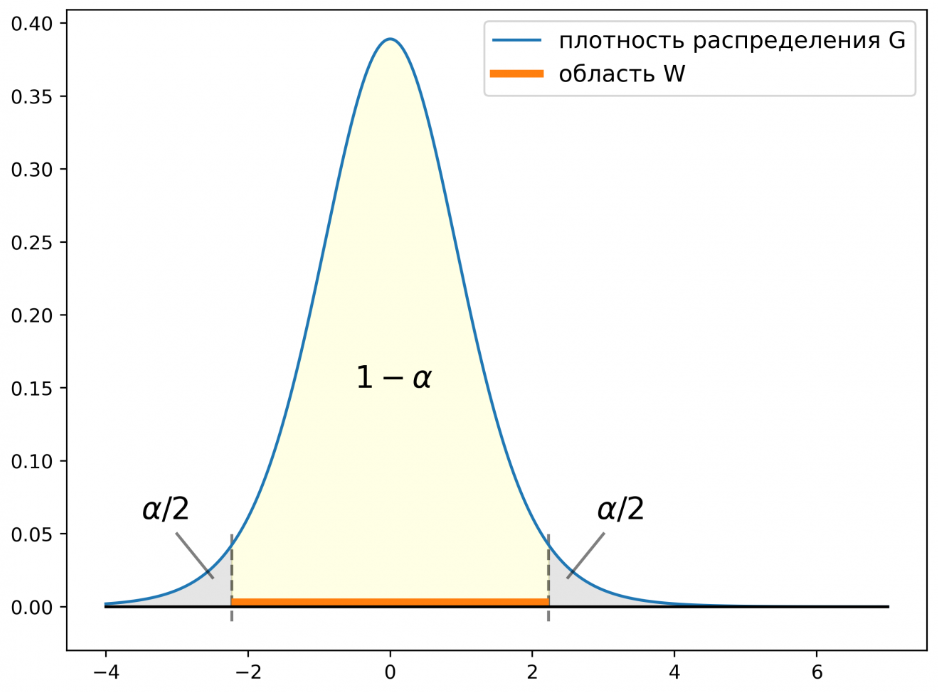

Чтобы построить критерий для проверки гипотезы о равенстве средних, нужно определить статистику и узнать её распределение при верности нулевой гипотезы.


В качестве статистики логично использовать разность средних. Оценить распределение статистики можно по историческим данным с помощью синтетических А/А тестов. Для каждого синтетического А/А теста вычислим и запомним значение статистики, повторим это большое количество раз. По полученным значениям можно оценить функцию распределения. Функция распределения сама по себе для принятия решения нам не нужна, нам нужно p-value. Сравнив p-value с уровнем значимости, решаем, отклонять нулевую гипотезу или нет.

$$
\text{p-value} = \left\{    \begin{aligned}     &\mathbb{P}(T \le t | H_0) &&,\text{для левосторонней гипотезы} \\     &\mathbb{P}(T \ge t | H_0) &&,\text{для правосторонней гипотезы} \\     &2\times\min\left(\mathbb{P}(T \le t | H_0),\ \mathbb{P}(T \ge t | H_0)\right) &&,\text{для двусторонней гипотезы} \\    \end{aligned} \right.
$$

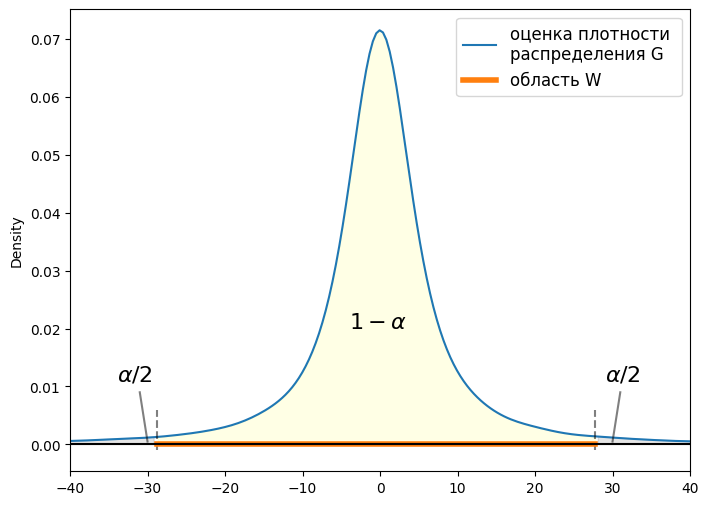

In [16]:
import seaborn as sns


def generate_statistic_values(history, sample_size, statistic_size):
    """Генерирует значения разности средних по историческим данным.

    history - исторические данные
    sample_size - размер выборки
    statistic_size - количество генерируемых данных

    return - массив со значениями разности средних
    """
    # для ускорения вычислений генерируем несколько групп за раз
    count_exp = len(history) // (2 * sample_size)
    statistic_list = []
    while len(statistic_list) < statistic_size:
        history_sample = np.random.choice(
            history, size=(count_exp, 2 * sample_size), replace=False
        )
        a_means = history_sample[:, :sample_size].mean(axis=1)
        b_means = history_sample[:, sample_size:].mean(axis=1)
        delta_means = b_means - a_means
        statistic_list += list(delta_means)
    statistic_array = np.array(statistic_list[:statistic_size])
    return statistic_array


alpha = 0.05
sample_size = 10
statistic_size = 100000
history_size = 1000000

history = np.random.lognormal(sigma=2, size=history_size)
statistic_values = generate_statistic_values(history, sample_size, statistic_size)

left_q, right_q = np.quantile(statistic_values, [alpha / 2, 1 - alpha / 2])
kde = sns.kdeplot(
    statistic_values, label="оценка плотности \nраспределения G", gridsize=10000
)
X, Y = kde.lines[0].get_data()
plt.plot([left_q, left_q], [-0.001, 0.006], "k--", alpha=0.5)
plt.plot([right_q, right_q], [-0.001, 0.006], "k--", alpha=0.5)
plt.plot([left_q, right_q], [0, 0], linewidth=4, label="область W")
plt.plot([min(X), max(X)], [0, 0], "k")
for mask in [X < left_q, X > right_q]:
    plt.fill_between(X[mask], np.zeros(sum(mask)), Y[mask], color="k", alpha=0.1)
mask = (X > left_q) * (X < right_q)
plt.fill_between(X[mask], np.zeros(sum(mask)), Y[mask], color="yellow", alpha=0.1)
plt.plot([-30, -31], [0.0005, 0.009], "k", alpha=0.5)
plt.plot([30, 31], [0.0005, 0.009], "k", alpha=0.5)
for x in [-34, 29]:
    plt.text(x, 0.011, "$\\alpha / 2$", size=16)
plt.text(-4, 0.02, "$1-\\alpha$", size=16)
plt.legend(fontsize=12)
plt.xlim([-40, 40])
plt.show()


Кроме оценки плотности распределения статистики мы также построили критическую область критерия для $\alpha=0.05$. Если статистика, рассчитанная по данным эксперимента, окажется в критической области, то отклоняем нулевую гипотезу о равенстве средних, иначе не отклоняем.


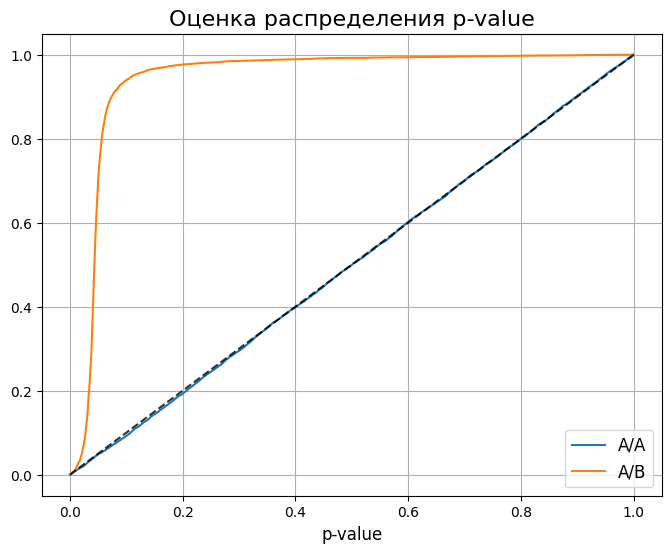

In [17]:
def check_my_statistical_test(a, b, statistic_values):
    """Проверяет гипотезу о равенстве средних.

    a - значения контрольной группы
    b - значения экспериментальной группы
    statistic_values - значения разности средних

    return - pvalue
    """
    pe = b.mean() - a.mean()
    part_less = np.mean(statistic_values < pe)
    pvalue = 2 * min(part_less, 1 - part_less)
    return pvalue


effect = 30

dict_pvalues = defaultdict(list)
for _ in range(10_000):
    a, b = np.random.lognormal(sigma=2, size=(2, sample_size))
    pvalue = check_my_statistical_test(a, b, statistic_values)
    dict_pvalues["A/A"].append(pvalue)
    b += effect
    pvalue = check_my_statistical_test(a, b, statistic_values)
    dict_pvalues["A/B"].append(pvalue)
plot_pvalue_distribution(dict_pvalues)


Описанный подход построения критерия является весьма универсальным - его можно использовать не только для проверки гипотезы о равенстве средних, но и для проверки других гипотез. Нужно выбрать подходящую статистику критерия и оценить её распределение по историческим данным при верности нулевой гипотезы.

Алгоритм построения и применения критерия:

1. Выберите статистику критерия, подходящую для проверяемой гипотезы.

2. Сгенерируйте множество значений статистики с помощью синтетические А/А тестов на исторических данных.

3. Вычислите значение статистики на данных эксперимента.

4. Оцените значение p-value для реализации статистики из п. 3 по множеству значений из п. 2



Плюсы: работает для любых гипотез и данных.

Минусы: нужны актуальные исторические данные, вычислительно затратно.